# Numerical Analysis of 2D Parallel-Plate Capacitor
Physical simulation of a two dimensional parallel-plate capacitor via SOR method for the electric potential

## 1. Imports
Modules used:
- Numpy: Use of numpy arrays for increased performance
- Matplotlib: Visualization of generated data
- Numba: Further performance improvement
- Time: Check elapsed time for convergence

In [99]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import time
from scipy import interpolate

## 2. Unidimensional Analysis
Testing the algorithm and the convergence criteria

Iterations: 199


Text(0, 0.5, 'Potential (V)')

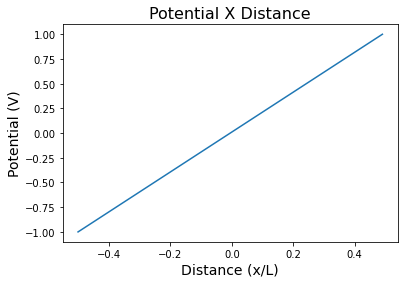

In [2]:
n = 100
initialGuess = np.zeros(n)
initialGuess[-1], initialGuess[0] = 1, -1
domain = np.arange(n)/n - 0.5
w = 1.941

def sorMethod1D(potential, convergenceCriteria, w):
    n = potential.shape[0]
    iterations = 0
    residue = 1
    wBest, nIterations = 0, 10000
    
    while residue > convergenceCriteria:
        iterations += 1
        formerPotential = np.copy(potential)
        for j in range(1, n-1):
            potential[j] = (1-w)*potential[j] + w*(potential[j-1] + potential[j+1])/2
        residue = np.linalg.norm(potential - formerPotential)
        if iterations >= 20000:
            print(f'Exceeded maximum iterations allowed (w = {w})')
            print(f'Current residue: {residue}')
            break        
    return (potential, iterations)

potentialBetweenPlates, iterations = sorMethod1D(initialGuess, 1e-4, w)


print(f'Iterations: {iterations}')
plt.plot(domain , potentialBetweenPlates)
plt.title("Potential X Distance", fontsize=16)
plt.xlabel("Distance (x/L)", fontsize=14)
plt.ylabel("Potential (V)", fontsize=14)

## 3. 2D Capacitor: Mesh Generation (1st Quadrant)
Due to symmetry, the electric potential will be solved only in the 1st quadrant.

Visualization of the mesh, potential will be calculated on blue points.
Red line indicates capacitor position


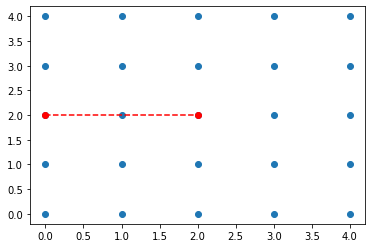

In [118]:
## Parameters ##
V0 = 1
lx = 2
d = 2
Dx, Dy = 2, 2
h = 0.5
Nx, Ny, Nh, Nl = int(Dx/h), int(Dy/h), int(d/(2*h)), int(lx/(2*h))
parameters = (Nx, Nh, Nl)
    
## Visualizing the Grid (1st quadrant) ##
x, y = np.meshgrid(np.linspace(0, Nx, Nx+1), np.linspace(0, Ny, Ny+1))

plt.scatter(x, y)

xCapacitor = np.array([0, Nl])
yCapacitor = np.array([Nh, Nh])

plt.plot(xCapacitor, yCapacitor, 'ro', linestyle='--')
print(f'Visualization of the mesh, potential will be calculated on blue points.')
print(f'Red line indicates capacitor position')

## 4. 2D Capacitor: SOR Method (1st Quadrant)

Iterations: 5
Test Cases:
V[0,1] = 0.244, V[0,3] = 0.244
V[1,1] = 0.238, V[1,3] = 0.238
V[2,1] = 0.208, V[2,3] = 0.208
V[3,1] = 0.095, V[3,3] = 0.095
V[3,2] = 0.172
Observation: Convergence Criteria was set to 1e-2 to get desired values


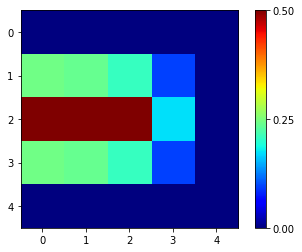

In [128]:
## Setting Initial Guess ##
initialGuess = np.resize(np.zeros(1), (Nx+1, Ny+1))
for i in range(Nl+1):
    initialGuess[i][-Nh-1] = 0.5*V0

## Convergence Criteria: Frobenius Norm ##
@jit(nopython=True)
def frobeniusNorm(vector):
    sumation = 0
    for row in vector:
        for el in row:
            sumation += el**2
    norm = (sumation)**0.5
    return norm    

## SOR Method for Test Case (1st quadrant) ##

@jit(nopython=True)
def sorMethod2D(potential, parameters, w=1, convergenceCriteria=1e-4):
    residue = 1
    iterations = 0
    Nx = parameters[0]
    Ny = Nx
    Nh = parameters[1]
    Nl = parameters[2]
    while residue > convergenceCriteria:
        iterations += 1
        formerPotential = np.copy(potential)
        for i in range(Nx):
            for j in range(1, Ny):
                if j == Ny-Nh and i <= Nl:
                    continue
                if i==0:
                    potential[i][j] = (1-w)*potential[i][j] + w*(potential[i][j-1] + potential[i][j+1] + potential[i+1][j] + potential[i][j])/4
                    continue
                potential[i][j] = (1-w)*potential[i][j] + w*(potential[i][j-1] + potential[i][j+1] + potential[i+1][j] + potential[i-1][j])/4
        residue = frobeniusNorm(potential - formerPotential)
        if iterations >= 50000:
            break
    return potential, iterations

potential, iterations = sorMethod2D(initialGuess, parameters, convergenceCriteria = 1e-2)

print(f'Iterations: {iterations}')
fig, ax = plt.subplots(1, 1)
im = ax.imshow(np.transpose(potential), cmap='jet')
fig.colorbar(im, ticks=[-0.5, -0.25, 0, 0.25, 0.5])

print(f'Test Cases:')
print(f'V[0,1] = {potential[0][1]:.3}, V[0,3] = {potential[0][3]:.3}')
print(f'V[1,1] = {potential[1][1]:.3}, V[1,3] = {potential[1][3]:.3}')
print(f'V[2,1] = {potential[2][1]:.3}, V[2,3] = {potential[2][3]:.3}')
print(f'V[3,1] = {potential[3][1]:.2}, V[3,3] = {potential[3][3]:.2}')
print(f'V[3,2] = {potential[3][2]:.3}')
print(f'Observation: Convergence Criteria was set to 1e-2 to get desired values')

## 5. Electric Potential on Entire Plane

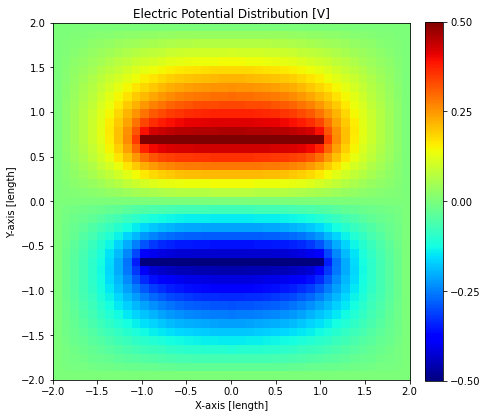

In [23]:
## Potential on XY Plane ##

def potentialOnPlane(potential):
    quarterPotential = np.transpose(potential)
    totalPotential = np.resize(np.zeros(1), (2*(Nx+1)-1, 2*(Ny+1)-1))
    for i in range(Nx+1):
        for j in range(Ny+1):
            totalPotential[i][Ny+j] = quarterPotential[i][j]
            totalPotential[i][j] = quarterPotential[i][-j-1]
            totalPotential[-i-1][j] = -totalPotential[i][j]
            totalPotential[-i-1][-j-1] = totalPotential[-i-1][j]
    return totalPotential

totalPotential = potentialOnPlane(potential)

## Plot Formatation ##
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)
im = ax.imshow(totalPotential, cmap='jet',extent=[-Dx, Dx, -Dy, Dy])
plt.title('Electric Potential Distribution [V]')
plt.xlabel('X-axis [length]')
plt.ylabel('Y-axis [length]')
fig.colorbar(im, ticks=[-0.5, -0.25, 0, 0.25, 0.5], fraction=0.046, pad=0.04)


## 6. Comparative Results for Different Domains
Checking how the boundaries, the element size and the convergence criteria affects elapsed time and precision.

Test Case: 1
Domain size: 6 X 6
Mesh size: (61, 61)
Element size: 0.1, nº of elements: 3721
Convergence Criteria: 0.0001
Iterations: 668
Execution time: 0.008007049560546875 seconds


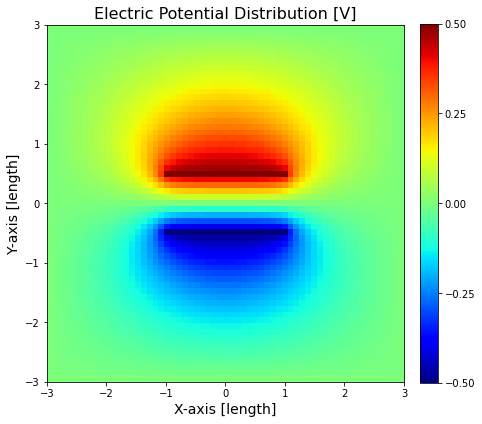

In [111]:
## Case 1 - Parameters ##
V0 = 1
lx = 2
d = 1
Dx, Dy = 3, 3
h = 0.1
Nx, Ny, Nh, Nl = int(Dx/h), int(Dy/h), int(d/(2*h)), int(lx/(2*h))
parameters = (Nx, Nh, Nl)

convergenceCriteria = 1e-4

initialGuess = np.resize(np.zeros(1), (Nx+1, Ny+1))
for i in range(Nl+1):
    initialGuess[i][-Nh-1] = 0.5*V0

startTime = time.time()

quadrantPotential, iterations = sorMethod2D(initialGuess, parameters, w=1, convergenceCriteria=convergenceCriteria)
totalPotential = potentialOnPlane(quadrantPotential)

stopTime = time.time()

print(f'Test Case: 1')
print(f'Domain size: {2*Dx} X {2*Dy}')
print(f'Mesh size: {totalPotential.shape}')
print(f'Element size: {h}, nº of elements: {totalPotential.shape[0]**2}')
print(f'Convergence Criteria: {convergenceCriteria}')
print(f'Iterations: {iterations}')
print(f'Execution time: {stopTime - startTime} seconds')

## Plot Formatation ##
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)
im = ax.imshow(totalPotential, cmap='jet',extent=[-Dx, Dx, -Dy, Dy])
plt.title('Electric Potential Distribution [V]', fontsize=16)
plt.xlabel('X-axis [length]', fontsize=14)
plt.ylabel('Y-axis [length]', fontsize=14)
fig.colorbar(im, ticks=[-0.5, -0.25, 0, 0.25, 0.5], fraction=0.046, pad=0.04)

Test Case: 2
Domain size: 8 X 8
Mesh size: (81, 81)
Element size: 0.1, nº of elements: 6561
Convergence Criteria: 0.0001
Iterations: 1161
Execution time: 0.019017934799194336 seconds


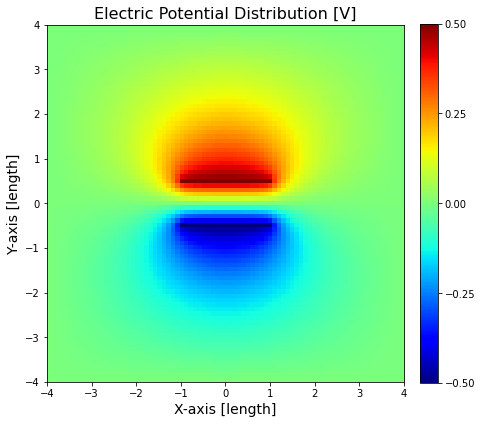

In [112]:
## Case 2 - Parameters ##
V0 = 1
lx = 2
d = 1
Dx, Dy = 4, 4
h = 0.1
Nx, Ny, Nh, Nl = int(Dx/h), int(Dy/h), int(d/(2*h)), int(lx/(2*h))
parameters = (Nx, Nh, Nl)
convergenceCriteria = 1e-4

initialGuess = np.resize(np.zeros(1), (Nx+1, Ny+1))
for i in range(Nl+1):
    initialGuess[i][-Nh-1] = 0.5*V0

startTime = time.time()

quadrantPotential, iterations = sorMethod2D(initialGuess, parameters, w=1, convergenceCriteria=convergenceCriteria)
totalPotential = potentialOnPlane(quadrantPotential)

stopTime = time.time()

print(f'Test Case: 2')
print(f'Domain size: {2*Dx} X {2*Dy}')
print(f'Mesh size: {totalPotential.shape}')
print(f'Element size: {h}, nº of elements: {totalPotential.shape[0]**2}')
print(f'Convergence Criteria: {convergenceCriteria}')
print(f'Iterations: {iterations}')
print(f'Execution time: {stopTime - startTime} seconds')

## Plot Formatation ##
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)
im = ax.imshow(totalPotential, cmap='jet',extent=[-Dx, Dx, -Dy, Dy])
plt.title('Electric Potential Distribution [V]', fontsize=16)
plt.xlabel('X-axis [length]', fontsize=14)
plt.ylabel('Y-axis [length]', fontsize=14)
fig.colorbar(im, ticks=[-0.5, -0.25, 0, 0.25, 0.5], fraction=0.046, pad=0.04)

Test Case: 3
Domain size: 8 X 8
Mesh size: (81, 81)
Element size: 0.1, nº of elements: 6561
Convergence Criteria: 1e-05
Iterations: 1687
Execution time: 0.02802419662475586 seconds


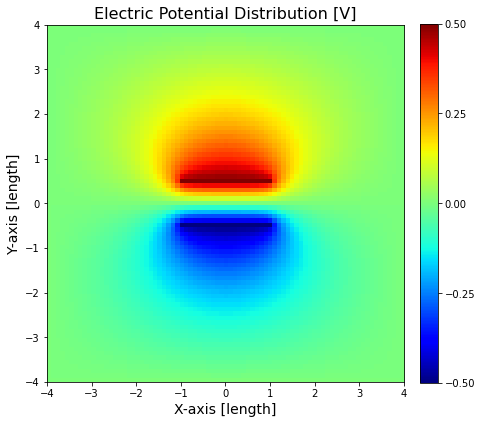

In [113]:
## Case 3 - Parameters ##
V0 = 1
lx = 2
d = 1
Dx, Dy = 4, 4
h = 0.1
Nx, Ny, Nh, Nl = int(Dx/h), int(Dy/h), int(d/(2*h)), int(lx/(2*h))
parameters = (Nx, Nh, Nl)
convergenceCriteria = 1e-5

initialGuess = np.resize(np.zeros(1), (Nx+1, Ny+1))
for i in range(Nl+1):
    initialGuess[i][-Nh-1] = 0.5*V0

startTime = time.time()

quadrantPotential, iterations = sorMethod2D(initialGuess, parameters, w=1, convergenceCriteria=convergenceCriteria)
totalPotential = potentialOnPlane(quadrantPotential)

stopTime = time.time()

print(f'Test Case: 3')
print(f'Domain size: {2*Dx} X {2*Dy}')
print(f'Mesh size: {totalPotential.shape}')
print(f'Element size: {h}, nº of elements: {totalPotential.shape[0]**2}')
print(f'Convergence Criteria: {convergenceCriteria}')
print(f'Iterations: {iterations}')
print(f'Execution time: {stopTime - startTime} seconds')

## Plot Formatation ##
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)
im = ax.imshow(totalPotential, cmap='jet',extent=[-Dx, Dx, -Dy, Dy])
plt.title('Electric Potential Distribution [V]', fontsize=16)
plt.xlabel('X-axis [length]', fontsize=14)
plt.ylabel('Y-axis [length]', fontsize=14)
fig.colorbar(im, ticks=[-0.5, -0.25, 0, 0.25, 0.5], fraction=0.046, pad=0.04)

Test Case: 4
Domain size: 8 X 8
Mesh size: (161, 161)
Element size: 0.05, nº of elements: 25921
Convergence Criteria: 1e-05
Iterations: 6054
Execution time: 0.2732582092285156 seconds


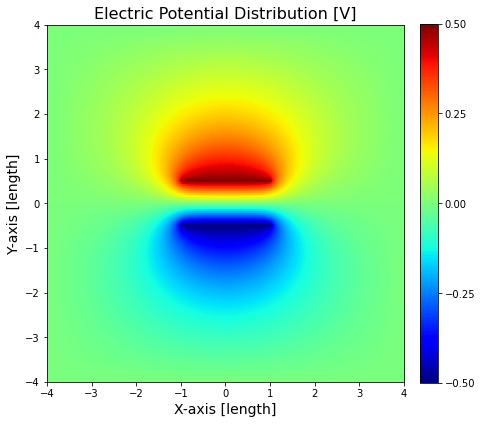

In [114]:
## Case 4 - Parameters ##
V0 = 1
lx = 2
d = 1
Dx, Dy = 4, 4
h = 0.05
Nx, Ny, Nh, Nl = int(Dx/h), int(Dy/h), int(d/(2*h)), int(lx/(2*h))
parameters = (Nx, Nh, Nl)
convergenceCriteria = 1e-5

initialGuess = np.resize(np.zeros(1), (Nx+1, Ny+1))
for i in range(Nl+1):
    initialGuess[i][-Nh-1] = 0.5*V0

startTime = time.time()

quadrantPotential, iterations = sorMethod2D(initialGuess, parameters, w=1, convergenceCriteria=convergenceCriteria)
totalPotential = potentialOnPlane(quadrantPotential)

stopTime = time.time()

print(f'Test Case: 4')
print(f'Domain size: {2*Dx} X {2*Dy}')
print(f'Mesh size: {totalPotential.shape}')
print(f'Element size: {h}, nº of elements: {totalPotential.shape[0]**2}')
print(f'Convergence Criteria: {convergenceCriteria}')
print(f'Iterations: {iterations}')
print(f'Execution time: {stopTime - startTime} seconds')

## Plot Formatation ##
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)
im = ax.imshow(totalPotential, cmap='jet',extent=[-Dx, Dx, -Dy, Dy])
plt.title('Electric Potential Distribution [V]', fontsize=16)
plt.xlabel('X-axis [length]', fontsize=14)
plt.ylabel('Y-axis [length]', fontsize=14)
fig.colorbar(im, ticks=[-0.5, -0.25, 0, 0.25, 0.5], fraction=0.046, pad=0.04)

Test Case: 5
Domain size: 10 X 10
Mesh size: (201, 201)
Element size: 0.05, nº of elements: 40401
Convergence Criteria: 1e-05
Iterations: 9232
Execution time: 0.6435928344726562 seconds


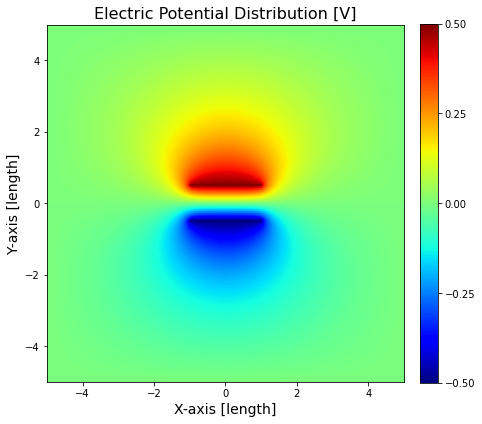

In [115]:
## Case 5 - Parameters ##
V0 = 1
lx = 2
d = 1
Dx, Dy = 5, 5
h = 0.05
Nx, Ny, Nh, Nl = int(Dx/h), int(Dy/h), int(d/(2*h)), int(lx/(2*h))
parameters = (Nx, Nh, Nl)
convergenceCriteria = 1e-5

initialGuess = np.resize(np.zeros(1), (Nx+1, Ny+1))
for i in range(Nl+1):
    initialGuess[i][-Nh-1] = 0.5*V0

startTime = time.time()

quadrantPotential, iterations = sorMethod2D(initialGuess, parameters, w=1, convergenceCriteria=convergenceCriteria)
totalPotential = potentialOnPlane(quadrantPotential)

stopTime = time.time()

print(f'Test Case: 5')
print(f'Domain size: {2*Dx} X {2*Dy}')
print(f'Mesh size: {totalPotential.shape}')
print(f'Element size: {h}, nº of elements: {totalPotential.shape[0]**2}')
print(f'Convergence Criteria: {convergenceCriteria}')
print(f'Iterations: {iterations}')
print(f'Execution time: {stopTime - startTime} seconds')

## Plot Formatation ##
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)
im = ax.imshow(totalPotential, cmap='jet',extent=[-Dx, Dx, -Dy, Dy])
plt.title('Electric Potential Distribution [V]', fontsize=16)
plt.xlabel('X-axis [length]', fontsize=14)
plt.ylabel('Y-axis [length]', fontsize=14)
fig.colorbar(im, ticks=[-0.5, -0.25, 0, 0.25, 0.5], fraction=0.046, pad=0.04)

## 7. How Varying W Affects Convergence

Varying W for Test Case: 4
Domain size: 8 X 8
Mesh size: (81, 81)
Element size: 0.05, nº of elements: 40401
Convergence Criteria: 1e-05
Execution time: 71.01749205589294 seconds


Text(0, 0.5, 'Number of Iterations')

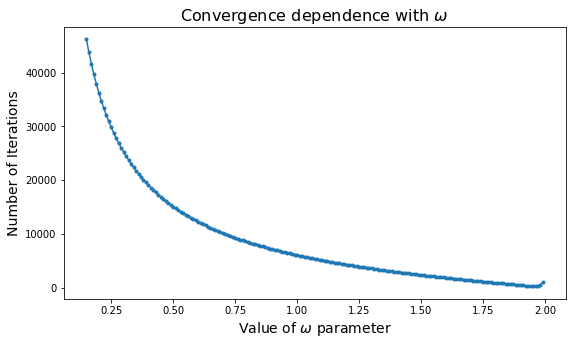

In [129]:
## Case 4 - Parameters ##
V0 = 1
lx = 2
d = 1
Dx, Dy = 4, 4
h = 0.05
Nx, Ny, Nh, Nl = int(Dx/h), int(Dy/h), int(d/(2*h)), int(lx/(2*h))
parameters = (Nx, Nh, Nl)
convergenceCriteria = 1e-5
    
initialGuess = np.resize(np.zeros(1), (Nx+1, Ny+1))
for j in range(Nl+1):
    initialGuess[j][-Nh-1] = 0.5*V0

print(f'Varying W for Test Case: 4')
print(f'Domain size: {2*Dx} X {2*Dy}')
print(f'Mesh size: {initialGuess.shape}')
print(f'Element size: {h}, nº of elements: {totalPotential.shape[0]**2}')
print(f'Convergence Criteria: {convergenceCriteria}')

iterationVector = []
wVector = []

start = time.time()

for i in range(150, 2000, 10):
    
    initialGuess = np.resize(np.zeros(1), (Nx+1, Ny+1))
    for j in range(Nl+1):
        initialGuess[j][-Nh-1] = 0.5*V0
    
    quadrantPotential, iterations = sorMethod2D(initialGuess, parameters, w=i/1000, convergenceCriteria=convergenceCriteria)
    wVector.append(i/1000)
    iterationVector.append(iterations)

tck = interpolate.splrep(wVector, iterationVector, s=0)   
ynew = interpolate.splev(wVector, tck, der=0)

stop = time.time()
print(f'Execution time: {stop-start} seconds')

fig, ax = plt.subplots()
fig.set_figwidth(9)
fig.set_figheight(5)
plt.scatter(wVector, iterationVector, marker='.')
plt.plot(wVector, ynew)
plt.title(r'Convergence dependence with $\omega$', fontsize=16)
plt.xlabel('Value of $\omega$ parameter', fontsize=14)
plt.ylabel('Number of Iterations', fontsize=14)

Text(0, 0.5, 'Number of Iterations')

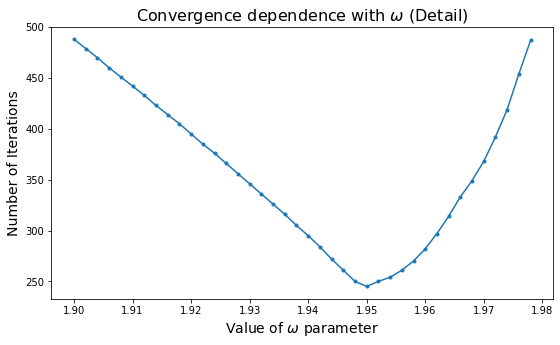

In [117]:
iterationVector = []
wVector = []

for i in range(1900, 1980, 2):
    
    initialGuess = np.resize(np.zeros(1), (Nx+1, Ny+1))
    for j in range(Nl+1):
        initialGuess[j][-Nh-1] = 0.5*V0
    
    quadrantPotential, iterations = sorMethod2D(initialGuess, parameters, w=i/1000, convergenceCriteria=convergenceCriteria)
    wVector.append(i/1000)
    iterationVector.append(iterations)

tck = interpolate.splrep(wVector, iterationVector, s=0)   
ynew = interpolate.splev(wVector, tck, der=0)

fig, ax = plt.subplots()
fig.set_figwidth(9)
fig.set_figheight(5)
plt.scatter(wVector, iterationVector, marker='.')
plt.plot(wVector, ynew)
plt.title(r'Convergence dependence with $\omega$ (Detail)', fontsize=16)
plt.xlabel('Value of $\omega$ parameter', fontsize=14)
plt.ylabel('Number of Iterations', fontsize=14)

## 8. Capacitance per Unit Lenght and Electric Field